# Design of a Balance of Plant System with Dynamic Networks
> Nik Kemper, Jack Kennedy and Valmor F. de Almeida <br>
> *nikolaus\_kemper@student.uml.edu, jack_kennedy@student.uml.edu and valmor\_dealmeida@uml.edu*<br>
>
> **University of Massachusetts Lowell** <br>
> Dept. of Chemical Engineering, Nuclear Energy Program, Lowell, MA, 01854, <br>
>
> **2021 Virtual SciPy Poster Session**<br>
> Tuesday, July 15, 2021 (2:15–4:00PM EDT) <br>
> Austin, TX (online)
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
  \DeclareMathOperator{\dt}{d_\textit{t}}
$

---
## Outline<a id="toc"></a>
* [Platform for network dynamics simulation: *Cortix*](#cortix)
* [BWR example](#bwr)
* [Final comments](#finalcomments)
---

## [A framework for system-level large scale modeling and simulation](#toc)<a id="cortix"></a>
1. `Cortix` framework for developing system-level applications
 - All-`python`, non-commercial free,  open-source [(download site)](https://cortix.org) development
1. Applications consist of a generic *bi-directional network* of stand-alone *computational modules*
 - Collection of coupled, reduced-order models
1. `Cortix` provides a single `Module` *class* for implementation of computational modules
 - Wrapper of the developer's computational module
 - Imposes *light* restrictions on the architecture of an existing code to allow for network coupling
1. `Module` is implemented using existing message passing parallel communication libraries for data coupling.
 - Developer does not need in-depth understanding of message passing
 - The understanding of a `Port` is required for effective communication programming
1. `Cortix` handles the connectivity of the network and delivery/receipt of messages
 - Messages can be any serializable form of data structured (*e.g.* time-stamped, events, etc.)
 - Framework is *hands-off* data; module developer handles the data
1. Framework assigns a process to each `Module` in the network
 - Application runs in parallel: either processes (MPI, `mpi4py`) or threads (`Python` `multiprocessing`)
 - Tested in HPC platforms, laptops, desktops, and the cloud: Linux, Mac, Windows (Anaconda/VM)
 - Scalability performance dependent on computational modules (`Network` and `Port` management is scalable)
1. `Cortix` is aimed at the HPC platform and uses the <span style="color:red">rich `Python` ecosystem</span>; 
 - <span style="color:red">Fully integrated into electronic `Jupyter` notebooks</span>: teaching, collaboration, development, and research

## [Divide and Couple Approach to Complex Systems](#toc)<a id="cortix2"></a>
An example of time-dependent system of coupled modules with indicated flow of information
<center>
<img width="500" src="figs/many-m.png" title="Module Network">
</center>

+ $M_i$: module of a reduced-order model
+ $\qvec_{\vec{i,j}}(t)$: coupling data vector (unknowns, and <span style="color:red">signals</span>)
+ $\pvec_{i}(\qvec_i, t)$: parameter vector (known function of time or unknowns)
<br>

Sources of mathematical computational and complexity:
 + Large scale connectivity (scaling up to realistic sizes)
 + Module behavior dependent on signals (on/off, breakdown, warming up, cooling down, *etc.*)
 
NB: Since `Cortix` is designed on the basis of *messages*, event-driven systems are equally supported.

## [Module Internals and Commonality](#toc)<a id="cortix2"></a>
Reduced-order models often share a common mathematical basis because of balance laws, *e.g.*

|  | | |
|---|--|---|
|<img width="300" src="figs/black-box.png" title="Module"> | >> INTERNALLY >> | <img width="600" src="figs/white-box.png" title="Module">|

+ $\Fvar(\cdot), \Gvar(\cdot), \Hvar(\cdot)$: behavior/model
+ $\uvec(t)$: state vector
+ $\pvec(t)$: parameter vector
+ $\qvec(t)$: coupling vector (depends on a subset of the state vector)

Often, the model is a system of non-linearly coupled ODEs.

## [Life of a Cortix Module](#toc)<a id="cortix2"></a>
<center>
<img width="300" src="figs/external-behavior.png" title="Module">
</center>

+ A module does not receive or send a message to itself
+ $M_i$ may evolve on its own time $t_i$
  - Requires a known parameter vector $\pvec_i(t_i)$
+ Coupling vectors $\qvec_{\vec{j, i}}(t_i)$ allow $M_i$ to use data from other modules in the network.
  - $M_i$ will *wait* for time-stamped coupling data $t_j$ via message passing (synchronization)

## [Time Evolution (uniform case)](#toc)<a id="cortix2"></a>

1. Initialize $t_0  = 0$ and $M_j\bigl(\uvec(t_0); \qvec(t_0), \pvec(t_0)\bigr)$ for all modules in the network.
1. For all $i = 1 \ldots n$:
 + Solve for $\uvec(t_i)$  $\forall$  $M_j\bigl(\uvec(t_i); \qvec(t_{i - 1}), \pvec(t_{i - 1})\bigr)$ independently.
 + Compute $\qvec(t_i), \pvec(t_i)$ and exchange information: $\qvec_{\vec{j, k}}(t_i)$.
 + Advance $t_{i + 1} \leftarrow t_i + \Delta t$ according to the configured time step.

### Comments
+ There is inevitable propagation of error in this explicit time evolution.
+ Modules must be loosely coupled components of the system; merge those that are tightly coupled into one.
+ Reduce the integration time step to the extent possible.

## [Modular Network Assembly](#toc)<a id="cortix2"></a>
+ An example of a modular network

In [1]:
'''Balance of Plant'''
# Framework
from cortix import Cortix
from cortix import Network

plant = Cortix()                      # System top level
plant_net = plant.network = Network() # Network

[4140] 2021-06-15 14:02:46,197 - cortix - INFO - Created Cortix object


In [2]:
'''Developer Reactor'''
from bop.reactor import BWR
from bop.params import get_params
params = get_params()
reactor = BWR(params)     # Create reactor module

plant_net.module(reactor) # Add reactor module to network

In [3]:
'''Developer Turbine High Pressure'''
from bop.turbine import Turbine
params['turbine_inlet_pressure'] = 2 # MPa
params['turbine_outlet_pressure'] = 0.5 # MPa
params['high_pressure_turbine'] = True
turb_hp = Turbine(params) # Create turbine
turb_hp.name = 'Turbine HP'

plant_net.module(turb_hp) # Add turbine module to network

In [4]:
'''Developer Turbine Low Pressure 1'''
params['turbine_inlet_pressure'] = 0.5 # MPa
params['turbine_outlet_pressure'] = 0.005 # MPa
params['high_pressure_turbine'] = False
params['steam flowrate'] = params['steam flowrate']/2
turb_lp1 = Turbine(params)  # Create turbine
turb_lp1.name = 'Turbine LP 1'
plant_net.module(turb_lp1)  # Add turbine module to network

In [5]:
'''Developer Turbine Low Pressure 2'''
params['turbine_inlet_pressure'] = 0.5 # MPa
params['turbine_outlet_pressure'] = 0.005 # MPa
params['high_pressure_turbine'] = False
turb_lp2 = Turbine(params)  # Create turbine
turb_lp2.name = 'Turbine LP 2'
plant_net.module(turb_lp2)  # Add turbine module to network

In [6]:
'''Developer Condenser'''
from bop.condenser import Condenser
condenser = Condenser()     # Create condenser
plant_net.module(condenser) # Add condenser module to network

In [7]:
'''Developer Residual Heat Removal System'''
from bop.rhrs import RHRS
import scipy.constants as unit
params['rhrs-shutdown-time'] = 5 * unit.minute
rhrs = RHRS(params)    # Create startup/shutdown heat removal
plant_net.module(rhrs) # Add cooler module to network

### Exchange of Information $\qvec_{\vec{j, k}}(t_i)$:
+ `Ports` are the mechanism for exchanging information.
+ `Ports` are provided in the `Module` class from `Cortix`.
+ Either the MPI or `Python` `multiprocessing` libraries are used.

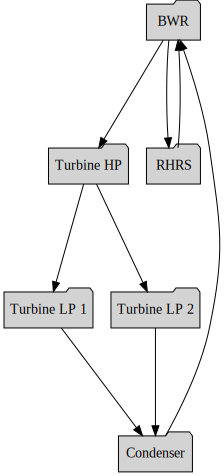

In [8]:
'''Framework Network Connectivity'''
# Connect an edge or pipe (ports are the ends of the edge)
plant_net.connect([reactor, 'coolant-outflow'], [turb_hp, 'inflow'])
plant_net.connect([turb_hp, 'outflow-1'], [turb_lp1, 'inflow'])
plant_net.connect([turb_hp, 'outflow-2'], [turb_lp2, 'inflow'])
plant_net.connect([turb_lp1, 'outflow-1'], [condenser, 'inflow-1'])
plant_net.connect([turb_lp2, 'outflow-1'], [condenser, 'inflow-2'])
plant_net.connect([condenser, 'outflow'], [reactor, 'coolant-inflow'])
plant_net.connect([reactor, 'rhrs-outflow'], [rhrs, 'coolant-inflow'])
plant_net.connect([rhrs, 'coolant-outflow'], [reactor, 'rhrs-inflow'])

plant_net.draw(engine='dot', node_shape='folder')

### Comments:
+ Note module reuse: `Turbine` instantiated 3 times.
+ Note that there is no parsing of an input file to setup system.
+ `Python` programming language is used to create the configuration file directly.

## [Scalability of Assembly (Ports and Pipes)](#toc)<a id="cortix2"></a>
+ Ports are cheap to create (little overhead) and can be created on the fly.
+ Example:

[4140] 2021-06-15 14:02:46,463 - cortix - INFO - Created Cortix object


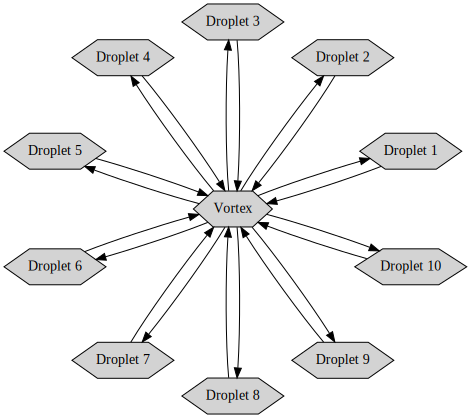

In [9]:
from cortix.examples.droplet_swirl.droplet import Droplet
from cortix.examples.droplet_swirl.vortex import Vortex

# Configuration Parameters
n_droplets = 10
  
swirl = Cortix()
swirl.network = Network()
  
# Vortex module (single).
vortex = Vortex()
swirl.network.module(vortex)

for i in range(n_droplets):
# Droplet modules (multiple).
    droplet = Droplet()
    droplet.name = 'Droplet %i'%(i+1)
    swirl.network.module(droplet)
  
# Network port connectivity (connect modules through their ports)
    swirl.network.connect([droplet, 'external-flow'],
                          [vortex, vortex.get_port('fluid-flow:{}'.format(i))], 'bidirectional')
  
swirl.network.draw(engine='twopi')

In [10]:
swirl.close()

[4140] 2021-06-15 14:02:46,599 - cortix - INFO - Closed Cortix object.
[4140] 2021-06-15 14:02:46,601 - cortix - INFO - close()::Elapsed wall clock time [s]: 0.14


### Comment
+ In cases with module repeatability the assembly process can be easily automated.

## [Problem Statement](#toc)<a id="ps"></a>

Consider a boiling water reactor, with UO$_2$ fuel and a light water moderator and coolant.
Given the neutron generation time $\ell$, delayed neutron fraction, $\beta$, decay constants of six-group delayed neutron emitters, $\lambda_i$, and corresponding yield of delayed neutron fractions for each emitter, $\beta_i$, calculate the pointwise neutron density variation with time for *varying* neutron reactivity, $\rho(t)$.

The neutron reactivity variation with time will depend indirectly on the effects of the balance of plant around the reactor including startup and shutdown transients. This will include a high pressure turbine, two low pressure turbines and a condenser (Fig. 1).

Steam is created from nuclear heat generated in the reactor and passed to the high-pressure turbine, which expands the steam to about 0.5 MPA (or 5 bar). The runoff from the high-pressure turbine is then split in half and fed to the two low-pressure turbines, which expand the runoff to 0.5 bar. The runoff is then fed to a condenser which produces subcooled liquid water, which is then fed back into the bottom of the reactor.

Modeling the entire network is accomplished through the use of the network simulation library [Cortix.](https://cortix.org). The individual plant components (reactor, turbines and condenser) are implemented as `Cortix` modules, with data exchange handled by the Cortix library.

Additionally, a number of the calculations used in this model rely on the [IAPWS](https://pypi.org/project/iapws/) library developed by Juan José Gómez Romera (jjgomera). IAPWS is the International Association for the Properties of Water and Steam, which develops power series that can be used to calculate properties of water and steam (such as specific enthalpy and entropy) at a variety of temperatures, pressures and qualities. The IAPWS library devloped by jjgomera implements these series as python functions which can be easily accessed and called to calculate any property required for thermodynamic calculations, drastically simplifying the process of modelling the two-phase systems in use by the turbine and condenser modules. This project specifically uses the IAPWS97 module within the library, which uses the formulations published in 1997 by IAPWS foundation as an update to ones developed in 1967. 

## [Module Basic Template for the Run Method](#toc)<a id="moduletemplate"></a>

```python
class BWR(Module): # inherit from the base class Module

    def run(self, *args):
          # Module's time loop
          while time <= self.end_time:
              # Specific coding goes here (operation, on-off, status, etc.)

              # Evolve one time step
              #---------------------
              time = self.__step(time)
        
              # Communicate information
              #------------------------
              self.__call_ports(time)
                
    def __step(self, time):
        # 1. Prepare module data for ODE solver        
        # 2. Call ODE solver
        # 3. Advance time
        time += self.time_step
        # 4. Update internal state data
        return time
    
     def __call_ports(self, time):

         # Interactions in the coolant-outflow port
         #-----------------------------------------
         # One way "to" coolant-outflow
  
         # Send to
         if self.get_port('coolant-outflow').connected_port:
  
              msg_time = self.recv('coolant-outflow')

              temp = self.coolant_outflow_phase.get_value('temp', msg_time)
              press = self.coolant_outflow_phase.get_value('pressure', msg_time)
  
              coolant_outflow = dict()
              coolant_outflow['temperature'] = temp
              coolant_outflow['pressure'] = press
  
              self.send((msg_time, coolant_outflow), 'coolant-outflow')
  
          # Interactions in the coolant-inflow port
          #----------------------------------------
          # One way "from" coolant-inflow
  
          # Receive from
          if self.get_port('coolant-inflow').connected_port:
  
              self.send(time, 'coolant-inflow')
  
              inflow_coolant = self.recv('coolant-inflow')
  
              self.coolant_mass_flowrate = inflow_coolant['mass_flowrate']
              self.coolant_quality = inflow_coolant['quality']
```

## [Brief Description of BWR Plant Modules](#toc)<a id="bwr"></a>

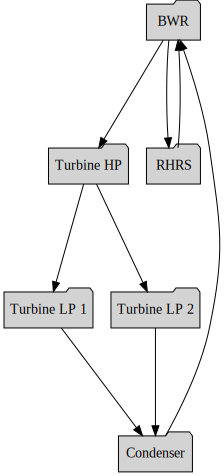

In [11]:
plant_net.draw(engine='dot', node_shape='folder')

---
## [Boiling Water Single-Point Reactor Model](#toc)<a id="bwr"></a>
Our model for the BWR module is one-group (no diffusion within the moderator assumed for leakage), tracks two temperatures (the uranium fuel and the water which acts as both a coolant and a moderator), and also behaves like a point reactor. This means that all of the kinetics, neutron density and heat generation is collapsed to a single point. Temperatures for the fuel and coolant are therefore averages of what they would be in a real reactor system.

A fission event releases heat and several neutrons; these neutrons go on to create more fission events, while the heat generated from the fissions is absorbed by the fuel. As the temperature of the fuel rises, it releases heat to the lower-temperature coolant, causing it to boil and produce steam. This steam then leaves off the top of the reactor, removing some heat from the system to be absorbed by the turbines and condensers later on down the line.


### [One-Group Energy  Neutron Balance](#toc)<a id="nbal"></a>

The space-invariant neutron balance for the point-reactor model is

\begin{equation*}
\frac{\text{d}n}{\text{d}t}  = \frac{\rho(t)-\beta}{\ell}\, n + \sum\limits_{i=1}^{6} \lambda_i\,c_i  + q(t),
\end{equation*}

where the first term on the right side of the equation represents the net production of neutrons not accounting for delayed neutrons (with $\rho(t)$ being the reactivity, $\beta$ being the delayed neutron fraction and $\ell$ being the prompt neutron lifetime), and the second term accounts for the source of delayed neutrons considering 6 groups of delayed neutron emitters resulting from the fission of $^{235}$U nuclei (with $\lambda$ being the decay constant of the specific delayed neutron precursor group, $c$ being its concentration and $q(t)$ being the magnitude of the neutron source, if any). Therefore a balance of neutron emitter species is also necessary

\begin{equation*}
\frac{\text{d}c_i}{\text{d}t}  = \frac{\beta_i}{\ell}\, n - \lambda_i\,c_i ,
     \ \ \ \ \ \forall \ \ \ \ \  i=1,\ldots,6.
\end{equation*}

where the first term on the right side of the equation is the source of emitters as a function of the neutron number density $n(t)$ (with $\beta$ being the yield of each delayed neutron precursor group from fission), and the second term is the consumption rate of the emitter by radioactive decay obtained as a function of the product of the number concentration of the emmiter, $c_i(t)$, multiplied by its decay constant $\lambda_i$. Here the number concentration of the $i$th emitter, $c_i$ is considered in terms of delayed neutron number density, hence the units are the same as $n$.

The current model considers the temperature reactivity coefficient, $\alpha_{T_n}$, that is, 

\begin{equation*}
 \rho(t) = \rho_0 + \alpha_{T_n}(T_f)\,\bigl(T_m(t) - T^{(0)}\bigr).
\end{equation*}

Where $\rho(0)$ is the initial reactivity insertion into the reactor, $\alpha_{T_N}$ is the overall temperature reactivity coefficient as a function of current temperature of the moderator $T_m(t)$, and $T^{(0)}$ is the reference temperature (298 $^{\circ}K$).

A heat balance in the static fuel dispersed into the moderator gives

\begin{equation*}
\frac{\text{d}T_f}{\text{d}t} = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr) 
\end{equation*}

Where $T_f$ is the temperature of the fuel, $\rho_f$ and $c_{pf}$ is its density and heat capacity, $q^{'''}(t)$ is the heat generated per unit volume within the fuel, $\dot Q_f$ is the rate of heat absorption from the fuel by the moderator and $V_f$ is the total volume of the fuel. 

The rate of heat absorption by the moderator is calculated by:

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr), 
\end{equation*}

Where $U$ and $A$ is the overall heat transfer coefficient and heat transfer area, $T_f$ is the temperature of the fuel and $T_c$ is the temperature of the moderator.

The rate of heat generation per unit volume within the fuel is equal to:

\begin{equation*}
q^{'''}(t) = G_f\frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}\,\biggl(\frac{\epsilon\,w_\text{fs}\,\rho_\text{fm}}{M_\text{fn}}\,i\,N_A\biggr)\,n(t)\,v_\text{(o)} .
\end{equation*}

Where $G_f$ is the energy released per fission, $\sigma_\text{fo}$ is the microscopic fission cross section within the fuel at a reference temperature $T^\text{(o)}$ of 298 $^{\circ} K$, $T$ is the current temperature of the fuel, $\epsilon$ is the fast fission factor, $\rho_\text{fm}$ is the mass density of the fuel, $M_\text{fn}$ is the molar mass of the fuel, $N_A$ is the number density of the fuel, $n(t)$ is the neutron density at that point in time and $v_\text{(o)}$ is the velocity of a thermal neutron.

A heat balance in the flowing coolant fluid produces

\begin{equation*}
\frac{\text{d}T_c}{\text{d}t} = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr) 
\end{equation*}

$T_c$ is the temperature of the coolant leaving the top of the reactor, $\tau_c$ is the coolant residence time within the reactor, $T_{in}$ is the temperature of the subcooled coolant entering the bottom of the reactor, $\rho_c$ is the density of the coolant, $c_{pc}$ is the heat capacity of the coolant and $V_c$ is the volume of the coolant (all properties of the coolant are calculated using the <span style="color:red">IAPWS97</span> `python` library. The heat rate source is the negative of the heat rate sink in the fuel/moderator.


### [Steady State](#toc)<a id="ss"></a>

Neutron density and delayed neutron precursor concentrations are related as follows:

\begin{align*}
n_\text{ss}  &= -\frac{q_\text{ss}\,\ell }{\rho_\text{ss} }
\\
c_{i_\text{ss}}  &= \frac{\beta_i}{\lambda_i\,\ell}\, n_\text{ss}   \ \ \ \ \forall \ \ \ \ i=1,\ldots,6 .
\end{align*}

### [Reactivity Feedback Model](#toc)<a id="feedbk"></a>
The moderator temperature reactivity coefficient is the major contributor to the power coefficient in a boiling water reactor. The power coefficient determines the feedback effect of increasing the power generated by the reactor (and therefore neutron density as well as heat generation). Generally, we see that increasing power will lead to an increase in the temperature of the water used to moderate the reactor. This will reduce the density of the water, and therefore its effectiveness as a moderator. We would expect that this would lead to lower reactivity, and the equation developed below reflects this. We can estimate the numerical effects of moderator temperature on reactivity by using a linearization of the effect of increasing temperature on the neutron multiplication factor ($K$), which is used to derive reactivity. 


\begin{equation*}
\alpha_\text{m} = \frac{dK}{dT_\text{m}}\frac{1}{K}\
\end{equation*}

Where $\alpha_\text{m}$ is the moderator temperature feedback coefficient, K is the neutron multiplication factor for a finite medium, and $T_\text{m}$ is the temperature of the moderator. K is calculated as follows:

\begin{equation*}
K = \frac{\eta \epsilon P F}{1 + (\tau + L^2) B^2 + \tau L^2 B^4}
\end{equation*}

Plugging this in to the original moderator temperature reactivity coefficient equation leaves the following differential equation:

\begin{equation*}
\alpha_\text{m} = \frac{d}{dT_\text{m}}\frac{1 + (\tau + L^2)B^2 + \tau L^2 B^4}{\eta \epsilon P F}\
\end{equation*}

With $\tau$ being the Fermi age or slowing down area, $L$ being the neutron diffusion length, $B$ being buckling, $\eta$ being neutron yield, $\epsilon$ being fast fission factor, $P$ being resonance escape probability and $F$ being thermal utilization. Only $\tau$, $P$ and $F$ vary significantly with moderator temperature, with $L$ and $B$ being assumed constants over the range of temperatures.

$\tau$ is found as follows:

\begin{equation*}
\tau = \frac{D_\text{f}}{\Sigma_\text{1}}
\end{equation*}

with $D_\text{f}$ being the diffusion coefficient and equal to:

\begin{equation*}
D_\text{f} = \frac{1}{3 \Sigma_\text{s}(1 - \mu_\text{0})}
\end{equation*}

With $\Sigma_\text{s}$ being the macroscopic scattering cross section, $\sigma_\text{s} N_\text{m}$, and $\mu_\text{0}$ being a constant dependent on the material used as the moderator.

$\Sigma_\text{1}$ is the neutron removal cross section, or the probability per unit length that a neutron becomes thermalized. It is calculated as:

\begin{equation*}
\Sigma_\text{1} = \frac{\xi \,\Sigma_\text{s}}{\ln \frac{E_\text{0}}{E_\text{th}} }
\end{equation*}

With $\xi$ being the average logarithmic energy decrement for a collision involving a neutron and the moderator (in the case of a light water reactor, $\xi$ = 1), $E_\text{0}$ being the energy of a neutron produced during fission (assumed to be constant at around 2 MeV), and $E_\text{th}$ being the energy of the medium that the neutron is diffusing through, which is dependent on the temperature of the moderator by the following equation:

\begin{equation*}
E_\text{th} = (T_\text{m})\frac{0.0862 \ MeV}{K}
\end{equation*}

With $T_\text{m}$ being in kelvin.

Assuming that only $N_\text{m}$ and $E_\text{th}$ vary with the temperature of the moderator, then the differential of $\tau$ with respect to $T_\text{m}$ may be calculated as follows:

\begin{equation*}
\frac{d \tau}{d T_\text{m}} = \frac{d}{d T_\text{m}} \frac{\frac{1}{3 \sigma_\text{s} N_\text{m}(1 - \mu_\text{0})}}{\frac{\xi \sigma_\text{s} N_\text{m}}{ln \frac{E_\text{0}}{E_\text{th}}}}
\end{equation*}

\begin{equation*}
\frac{d \tau}{d T_\text{m}} = \frac{(0.0862\frac{E_\text{th}}{E_\text{0}})(3  N_\text{m} )-(ln \frac{E_\text{0}}{E_\text{th}})(6 \frac{d N_\text{m}}{d T_\text{m}})}{(3 N_\text{m})^2 (1 - \mu_\text{0})}
\end{equation*}

Next, the diffusion area in the moderator before absorption, $L^2$, may be evaluated. It can be calculated through the following relation:

\begin{equation*}
L^2 = \frac{1}{3 \Sigma_\text{s} \Sigma_\text{a} (1 - \mu_\text{0})}
\end{equation*}

And therefore:

\begin{equation*}
L = \sqrt{\frac{1}{3 \Sigma_\text{s} \Sigma_\text{a} (1 - \mu_\text{0})}}
\end{equation*}

Note that L is referred to as the diffusion length whereas $L^2$ is the diffusion area.

Taking the derivative of the diffusion length, L, with respect to time, and noting that only the number density of the moderator varies with time, and that the macroscopic cross sections $\Sigma$ can be rewritten as $\sigma$ $N_\text{m}$, we obtain the differential of diffusion length with respect to time:

\begin{equation*}
\frac{dL}{dT_\text{m}} =  \frac{1}{2 \sqrt{\frac{-2 \frac{dN_\text{m}}{dT_\text{m}}}{3 \sigma_\text{s} \sigma_\text{a} N_\text{m}^3 (1 - \mu_\text{0})}}}
\end{equation*}

Next, the terms in the four factor formula, $\eta \ , \ \epsilon \ , \ P, \ F$ must be developed and the derivatives of the ones which vary with moderator temperature must be calculated.

$\eta$ and $\epsilon$ do not vary with moderator temperature, and are assumed to have constant values of 2.02 and 1.03.

$P$, the resonance escape, is calculated via the following equation:

\begin{equation*}
P = e^{ - \frac{N_\text{f}\, V_\text{F}\, I}{\xi\, \Sigma_\text{s  M} V_\text{M}} }
\end{equation*}

In the above equation, $N_\text{f}$ is the number density of the fuel, $V_\text{F}$ is the volume of the fuel, $I$ is the resonance escape integral, and $V_\text{M}$ is the volume occupied by the moderator.

With only the macroscopic scattering cross section of the moderator varying with temperature of the moderator (volume of coolant in the core is assumed constant, only the density changes), the derivative of the resonance escape probability with respect to the temperature of the moderator can be calculated as:

\begin{equation*}
\frac{dP}{dT_\text{m}} =  \frac{-N_\text{f} V_\text{F} I \sigma_\text{s} \frac{dN_\text{m}}{dT_\text{m}}}{(\xi \Sigma_\text{s  M} V_\text{M})^2}e^{- \frac{N_\text{f} V_\text{F} I}{\xi \Sigma_\text{s  M} V_\text{M}}}
\end{equation*}

The thermal utilization, $F$, is calculated as follows:

\begin{equation*}
F = \frac{\Sigma_\text{aF}}{\Sigma_\text{aF} + \Sigma_\text{aM}}
\end{equation*}

With $\Sigma_\text{aF}$ being the macroscopic absorption cross section of the fuel and $\Sigma_\text{aM}$ being the macroscopic absorption cross section of the moderator. As only the macroscopic absorption cross section of the moderator will vary with the temperature of the moderator, the derivative of thermal utilization with respect to the temperature of the moderator can be written as follows:

\begin{equation*}
\frac{dF}{dT_\text{m}} = \frac{-(\Sigma_\text{aF})(\sigma_\text{aM} \frac{dN_\text{m}}{dT_\text{m}})}{(\Sigma_\text{aF} + \Sigma_\text{aM})^2}
\end{equation*}

The final preliminary differential equation is the one that must be developed for the differential of the moderator number density with respect to the temperature of the moderator. The change in number density of the moderator with respect to temperature will be proportional to the change in the mass density of the moderator with respect to temperature, by the molar mass of the moderator (in this case, 18 g/mol) and Avogadro's number. The derivative of the mass density with respect to the temperature of the moderator of water is a function of a forty term polynomial used by the <span style="color:red">IAPWS 97</span> standards to approximate the behavior of water at different temperatures and pressures, that is:

\begin{equation*}
\frac{d \rho}{dT_\text{m}} = \frac{d}{dT_\text{m}}(IAPWS(T))
\end{equation*}

The derivative can be approximated by using scipy's inbuilt differentiation function. From there, the differential of mass density with respect to moderator temperature may be related to the differential of number density with respect to moderator temperature by the molar mass and avogadro's number:

\begin{equation*}
\frac{dN_\text{m}}{dT_\text{m}} = (18 g/mol)(N_\text{A})(\frac{d \rho}{dT_\text{m}})
\end{equation*}

Now that all previous relationships have been developed, the moderator temperature feedback coefficient can be calculated. Recall the original equation for the moderator temperature feedback coefficient:

\begin{equation*}
\alpha_\text{m} = \frac{d}{dT_\text{m}}\frac{1 + (\tau + L^2)B^2 + \tau L^2 B^4}{\eta \epsilon P F}\
\end{equation*}

Taking the derivatives with respect to moderator temperature yields the following differential:

\begin{equation*}
\alpha_\text{m} = \frac{(\eta \epsilon P F)((\frac{d \tau}{dT_\text{m}})(B^2 + L^2 B^4)+(\frac{dL}{dT_\text{m}})(2L B^2 + 2L \tau B^4))-(1 + (\tau + L^2)B^2 + \tau L^2 B^4)(\eta \epsilon)(F \frac{dP}{dT_\text{m}} + P \frac{dF}{dT_\text{m}})} {(\eta \epsilon P F)^2}
\end{equation*}

---
## [Turbine Model](#toc) <a id="tub"></a>
A boiling water reactor will typically use several different turbines, either designed to expand high-pressure steam drawn directly off the top of the reactor, or to expand lower-pressure runoff steam drawn from the high-pressure turbines. This is typically done to improve thermodynamic efficiency and avoid condensation of the steam within the turbines themselves. This simplified model contains a single high-pressure turbine which expands steam coming off the top of the reactor to around 5 bar; There are also two low-pressure turbines which expand the runoff from the high-pressure turbine to 0.05 bar. Both of these different types of turbine use the same model but different parameters to determine runoff temperature and the amount of power generated.

A basic heat balance on the turbine gives:

\begin{equation*}
Q + W_\text{s} = \bigl(\Delta H + \Delta K + \Delta Z\bigr)\,\dot m
\end{equation*}

With $Q$ being the heat into or out of the system, $W$ being the work done by the working fluid (and hence being positive if the turbine is producing useful work), and with $\Delta$H, $\Delta$K and $\Delta$Z representing the changes in enthalpy, kinetic energy and gravitational potential energy of the fluid on a per-kilogram basis, respectively. $\dot m$ is the mass flowrate of fluid through the turbine.  It is assumed that the turbine operates adiabatically and with no change in the kinetic or gravitational potential energy of the fluid as it moves through the turbine. Hence, the equation reduces to:

\begin{equation*}
W_\text{s} = \Delta H \dot m
\end{equation*}

If the turbine is producing useful work, then $W$ is positive, and hence $\Delta$H must be positive as well. The enthalpy of the fluid will decrease as it passes through the turbine and is expanded to a lower temperature and pressure, hence the equation can be rewritten as:

\begin{equation*}
-W_\text{s} = -\Delta H \dot m = \bigl(H_\text{outlet} - H_\text{inlet}\bigr)\,\dot m 
\end{equation*}

Which can then be re-arranged as:

\begin{equation*}
W_\text{s} = \Delta H \dot m = \bigl(H_\text{inlet} - H_\text{outlet}\bigr)\,\dot m 
\end{equation*}

If conditions of the inlet steam are given, either being the same temperature and pressure of the steam leaving the top of the reactor (in the case of a high-pressure turbine), or having the runoff temperature and pressure of steam leaving a high-pressure turbine (in the case of a low-pressure turbine). The exit pressure of the steam leaving the turbine is similarly fixed by the design pressure of the turbine ($P_\text{turbine}$, 5 bar in the case of a high-pressure turbine, 0.05 bar in the case of a low-pressure turbine).  Therefore, the above equation can be rewritten as:

\begin{equation*}
W_\text{s} = \bigl(H_\text{inlet}(T_\text{inlet}, P_\text{inlet}) - H_\text{outlet}(T_\text{runoff}, P_\text{turbine})\bigr)\,\dot m
\end{equation*}

It should be noted that the turbines are not assumed to operate isentropically, but instead at around 80% of the maximum isentropic work for any given steam inlet properties.

We denote the maximum possible isentropic work of the turbine, $W_\text{isentropic}$, as the amount of work that would be done if the steam entering the turbine was expanded to a pressure $P_\text{turbine}$ and a temperature which would give the same enthalpy as steam of temperature $T_\text{inlet}$ and pressure $P_\text{inlet}$, that is

\begin{equation*}
W_\text{isentropic} = \bigl(H_\text{inlet}(T_\text{inlet}, P_\text{inlet}) - H_\text{outlet}(T_\text{isentropic} ,P_\text{turbine} )\bigr)\dot m
\end{equation*}

Actual work performed by the turbine can then be determined by simply multiplying the known efficiency by the calculated isentropic work.

\begin{equation*}
W_\text{real} = 0.8 \, W_\text{isentropic}
\end{equation*}

And, by an energy balance, we can calculate the ending enthalpy of the liquid runoff at $P_\text{turbine}$, $H_\text{real runoff}$:

\begin{equation*}
H_\text{real runoff}(T_\text{real}, P_\text{turbine}) = \frac{W_\text{real}}{\dot m} - H_\text{inlet}(T_\text{inlet}, P_\text{inlet})
\end{equation*}

With the ending enthalpy of the liquid runoff known, and its pressure fixed by the output pressure of the turbine, the runoff temperature and quality of the liquid from the turbine can be calculated using the <span style="color:red">IAPWS97</span> backwards solver functions. To do this, $H_\text{real runoff}$ is first compared to the dew and bubble point enthalpies of water at the runoff pressure to arrive at the runoff quality:

\begin{equation*}
X_\text{runoff} = \frac{H_\text{real runoff} - H_\text{bubl pt}}{H_\text{dew pt} - H_\text{bubl pt}}
\end{equation*}

If $X_\text{runoff}$ is greater than 1, then the runoff will be a superheated vapor. If it is less than 0, then it will be a subcooled liquid. In either case, the runoff temperature can then be calculated by finding the superheated vapor or liquid with the same enthalpy $H_\text{real runoff}$ and the turbine runoff pressure, using an <span style="color:red">IAPWS97</span> backwards solver function. If $X_\text{runoff}$ is between 0 and 1, this indicates that the runoff is a two-phase mixture with a temperature fixed by the boiling point of the liquid at the specified runoff pressure.

---
## [Condenser Model](#toc) <a id="cond"></a>
The condenser takes the runoff from the low-pressure turbines and condenses it into a subcooled liquid to be fed back into the bottom of the reactor. In theory, the runoff from the turbines can be a two-phase mixture, a bubble-point liquid, a dew-point vapor or even superheated vapor. In practice, however, the runoff from the low-pressure turbines is only a two-phase mixture of varying composition for the duration of the simulation.

The first thing the condenser model calculates is the amount of energy which must be withdrawn from the turbine runoff to cool it to its dew point. This is calculated by:

\begin{equation*}
Q = \bigl(H_\text{real runoff} - H_\text{bubl pt}\bigr)\,\dot m
\end{equation*}

This will be used to determine how much of the condenser's cooling capacity is used to bring the incoming liquid down to the bubble point temperature, and how much of this capacity will be left to subcool it. With the actual condensation duty known, an accurate number for cooling capacity at the current input composition and pressure must be determined. We start by determining the log-mean temperature difference for the condensation, which is calculated by:

\begin{equation*}
\Delta T_\text{lm} = \frac{T_\text{c out} - T_\text{c in}}{\ln\Bigl(\frac{T_\text{critical} - T_\text{c in}}{T_\text{boiling pt} - T_\text{c out}}\Bigr)}
\end{equation*}

Where $T_\text{c out}$ is the temperature of the cooling water leaving the condensation stage, $T_\text{c in}$ is the temperature of the cooling water entering the condensation stage and $T_\text{boiling pt}$ is the boiling point temperature of the turbine runoff at the turbine runoff pressure. With $T_\text{c in}$ and $Q$ known, the runoff temperature of the cooling water can be calculated from the following equation:

\begin{equation*}
T_\text{c out} = T_\text{c in } + \frac{Q}{\dot m \, c_\text{p}},
\end{equation*}

where here $\dot m$ is the cooling water mass flowrate, not the mass flowrate leaving the turbines. $c_\text{p}$ is the heat capacity of the coolant in this case. The resulting $T_\text{c out}$ may then be plugged into the expression for log mean temperature difference. In order to arrive at an accurate overall heat transfer coefficient for the condensation operation, the McNaught expression is used

\begin{equation*}
\alpha_\text{sh} = \alpha_\text{l} \Bigl(\frac{1}{x_\text{tt}}\Bigr)^{0.78},
\end{equation*}

where $\alpha_\text{sh}$ is the overall heat transfer coefficient, $\alpha_\text{l}$ is the heat transfer coefficient for a liquid water mixture at the same temperature and pressure as the turbine runoff flowing over a tube (calculated using the Churchill-Bernstein correlation), and $x_\text{tt}$ is the Martinelli parameter. The Martinelli parameter can be calculated using the following expression:

\begin{equation*}
x_\text{tt}^2 = \Bigl(\frac{1 - x}{x}\Bigr)^{1.8}\Bigl(\frac{\rho_\text{dew pt}}{\rho_\text{bubbl pt}}\Bigr)\Bigl(\frac{\eta_\text{bubbl pt}}{\eta_\text{dew pt}}\Bigr)^{0.5},
\end{equation*}

where x is the quality of the steam entering the turbine, $\rho$ is the mass density of either the dew point or bubble point mixture at the turbine runoff pressure, and $\eta$ is the viscocity of either the dew point or bubble point mixture at the turbine runoff pressure. With the overall heat transfer coefficient, $Q$ and the temperature driving force $\Delta T_\text{lm}$ known, we can calculate the amount of cooling capacity left to subcool the condensate by determining the amount of heat transfer area that hasn't been used:

\begin{equation*}
A = \frac{Q}{\alpha_\text{sh} \Delta T_\text{lm}}
\end{equation*}

The total area (and therefore capacity) remaining for subcooling may then be found by subtracting the above result from the total heat transfer area of the condenser. 

Subcooling proceeds slightly differently than the algorithm for determining remaining capacity after condensation. It is an iterative process which begins with a guess for the temperature of the cooling water leaving the condenser. With this guess, a preliminary value for the runoff temperature of the process fluid from the condenser may be generated by performing a heat balance between the process fluid (turbine runoff) and the cooling water (note that for this section "c in" refers to the temperature of the coolant leaving the condensation stage and "c out" refers to the runoff temperature of the coolant leaving the condenser itself):

\begin{equation*}
T_\text{process out} = T_\text{boiling pt} - \frac{\dot m_\text{coolant}\, c_\text{p coolant} \, \Delta T_\text{coolant}}{\dot m_\text{process}\, c_\text{p process}}
\end{equation*}

Where $\Delta T_\text{coolant}$ is the difference between the temperature of the coolant after the condensation step and the guessed value for the temperature of the coolant leaving the condenser (that is, $T_\text{c runoff} - T_\text{c out}$. With $T_\text{process out}$ known, a log-mean temperature difference for this cooling operation may be calculated (assuming parallel flow):

\begin{equation*}
\Delta T_\text{lm} = \frac{\bigl(T_\text{boiling pt} - T_\text{c out}\bigr) - \bigl(T_\text{process out} - T_\text{c in}\bigr)}{\ln\Bigl(\frac{T\text{boiling pt} - T_\text{c out}}{T_\text{process out} - T_\text{c in}}\Bigr)}
\end{equation*}

An overall heat transfer coefficient for this iteration may then be obtained using the Churchill-Bernstein correlation. Taking into account the remaining area, the overall heat transfer coefficient and the temperature driving force, a Q may then be calculated:

\begin{equation*}
Q = \alpha \, A_\text{remaining} \Delta T_\text{lm}
\end{equation*}

With this Q, we may loop back around and calculate a new 'guess' value for the runoff temperature of the coolant by another energy balance:

\begin{equation*}
T_\text{c out} = T_\text{c in} + \frac{Q}{\dot m_\text{coolant} \, c_\text{p coolant}}
\end{equation*}

With a new value for $T_\text{c out}$ obtained that is closer to the actual value, the algorithm may be repeated until it converges on a suitably accurate value (for the purposes of our code, within +/- 0.01 $^{\circ}$C. When the value for $T_\text{c out}$ converges, we will be left with a suitable estimation for the temperature of the subcooled process fluid leaving the condenser and being fed back into the bottom of the reactor.

## [Network Simulation Results](#toc) <a id="cortix"></a>

In [12]:
'''Running a BOP Startup'''

# BOP time evolution config
end_time = 300.0 * unit.minute
time_step = 60.0
show_time = (True, 30*unit.minute)
params['start-time'] = 0.0
params['end-time'] = end_time

# Reactor config
reactor.save = True
reactor.time_step = time_step
reactor.end_time = end_time
reactor.show_time = show_time
reactor.rhrs = True
reactor.rhrs_operating_mode = 'online'

# High-pressure turbine config
turb_hp.save = True
turb_hp.time_step = time_step
turb_hp.end_time = end_time

# Low-pressure turbine 1 config
turb_lp1.save = True
turb_lp1.time_step = time_step
turb_lp1.end_time = end_time

# Low-pressure turbine 2 config
turb_lp2.save = True
turb_lp2.time_step = time_step
turb_lp2.end_time = end_time

# Condenser config
params['steam flowrate'] = params['steam flowrate'] * 2
condenser.params = params
condenser.save = True
condenser.time_step = time_step
condenser.end_time = end_time

# RHRS config
rhrs.save = True
rhrs.time_step = time_step
rhrs.end_time = end_time

# Run network dynamics simulation
plant.run()

[4140] 2021-06-15 14:02:46,704 - cortix - INFO - Launching Module <bop.reactor.BWR object at 0x7f47c36888e0>
[4140] 2021-06-15 14:02:46,712 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7f47c1e70b50>
[4140] 2021-06-15 14:02:46,714 - cortix - INFO - BWR::run():time[m]=0.0
[4140] 2021-06-15 14:02:46,722 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7f47c1e97b80>
[4140] 2021-06-15 14:02:46,730 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7f47c1e97310>
[4140] 2021-06-15 14:02:46,737 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7f47e02366d0>
[4140] 2021-06-15 14:02:46,743 - cortix - INFO - Launching Module <bop.rhrs.RHRS object at 0x7f47c1e70820>
[4140] 2021-06-15 14:04:00,661 - cortix - INFO - BWR::run():time[m]=30.0
[4140] 2021-06-15 14:05:38,745 - cortix - INFO - BWR::run():time[m]=60.0
[4140] 2021-06-15 14:07:05,013 - cortix - INFO - BWR::run():time[m]=90.0
[4140] 2021-06-15 14:08:23,795 - cort

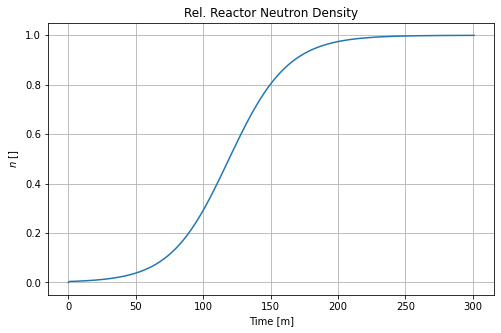

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5] 

reactor = plant_net.modules[0] # retrieve data

(quant, time_unit) = reactor.neutron_phase.get_quantity_history('neutron-dens')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.latex_name+' []')
plt.grid()

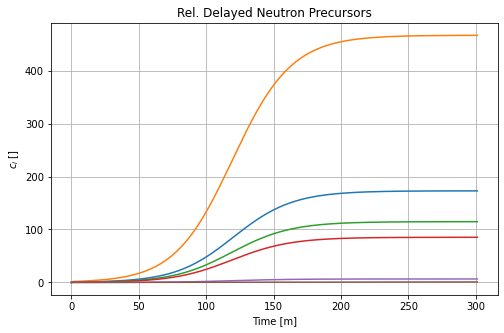

In [20]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('delayed-neutrons-cc')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.latex_name+' []')
plt.grid()

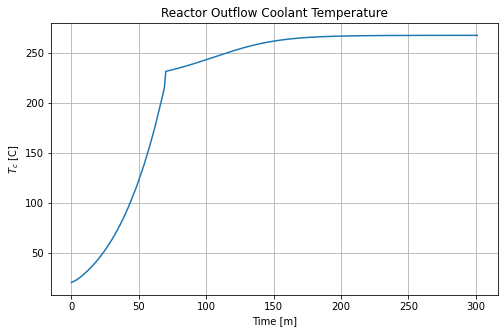

In [21]:
(quant, time_unit) = reactor.coolant_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, y_shift=273.15,
           x_label='Time [m]', 
           y_label=quant.latex_name+' [C]')
plt.grid()

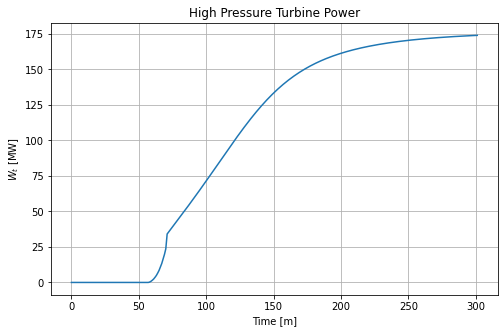

In [22]:
turb_hp = plant_net.modules[1] # retrieve data

(quant, time_unit) = turb_hp.outflow_phase.get_quantity_history('power')
quant.plot(x_scaling=1/unit.minute, y_scaling=1/unit.mega,
           x_label='Time [m]', y_label=quant.latex_name+' [M'+quant.unit+']',
           title='High Pressure Turbine Power')
plt.grid()

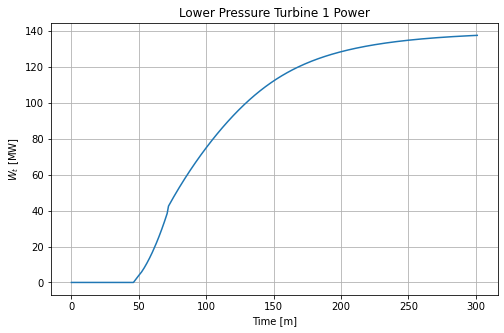

In [23]:
turb_lp1 = plant_net.modules[2] # retrieve data

(quant, time_unit) = turb_lp1.outflow_phase.get_quantity_history('power')
quant.plot(x_scaling=1/unit.minute, y_scaling=1/unit.mega, 
           x_label='Time [m]', y_label=quant.latex_name+' [M'+quant.unit+']',
           title='Lower Pressure Turbine 1 Power')
plt.grid()

In [18]:
plant.close()  # Properly shutdow plant

[4140] 2021-06-15 14:19:25,934 - cortix - INFO - Closed Cortix object.
[4140] 2021-06-15 14:19:25,935 - cortix - INFO - close()::Elapsed wall clock time [s]: 999.74


## [Final Comments](#toc)<a id="finalcomments"></a>

+ Sub-scaling, higher-order modeling and simulation could be supported in HPC platforms:
 - Additional work needed to create pools of processes.
 
+ Systems of systems is also a possibility:
 - Sub-networks or nested networks needs to be implemented.
 
+ This development is invaluable for agile prototyping, collaboration, teaching and research.
+ Leveraging data science developments in this area is very instructive for training new generations of computationally oriented engineers.

Thank you for attending.

## [Acknowledgements](#toc)<a id="ackn"></a>

This work was partially funded by the [Francis College of Engineering at UMass Lowell](https://www.uml.edu/engineering/), Department of Chemical Engineering (Nuclear Program), and the [Cortix](https://cortix.org) group.

During startup, the neutron density follows a predictable sigmoid shape (Fig. 2), rapidly shooting up and then slowing down until steady state is reached (1.0 being the reactor steady state neutron density). Steady-state is maintained for about 20 minutes until the reactor enters shutdown and neutron density gradually drops to zero.

Neutron density also drops slightly about 15 minutes after steady state is reached. High moderator temperature results in negative reactivity insertion and a corresponding drop in neutron density.

|  |
|---|
| <img width="700" src="pictures/neutron-dens.png" title="Neutron Density">|
| <p style="text-align:center;"><b>Fig. 2: Neutron density time-variation during startup and shutdown.</b></p> |

The six delayed neutron emitter groups follow a similar pattern to neutron density during startup and shutdown (Fig. 3), the difference in levels being due to the different $\beta_i$ yields given in the one-group neutron energy balance. This plot (Fig. 3) shows the relative abundance of each of the delayed neutron precursor groups, in relation to steady state reactor neutron density. The small drop in density observed in the neutron density around the 25 minute mark can also be observed here.

|  |
|---|
| <img width="700" src="pictures/delayed-neutrons-cc.png" title="Delayed Neutron Emitters">|
| <p style="text-align:center;"><b>Fig. 3: Delayed emitter concentrations variation with time.</b></p> |


Fuel temperature (Fig. 4) follows the neutron density curve fairly closely, which is to be expected since higher neutron density will generate more nuclear heat. The starting and ending temperatures are both room temperature at 297 $^{o}K$.

|  |
|---|
| <img width="700" src="pictures/fuel-temp.png" title="Average Fuel Temperature">|
| <p style="text-align:center;"><b>Fig. 4:Average fuel temperature variation with time.</b></p> |


Coolant temperature (Fig. 5) follows the neutron density curve fairly closely, which is to be expected since more nuclear heat generation will result in a higher runoff coolant temperature.  The starting and ending temperatures are both room temperature at 297 $^{o}K$.

|  |
|---|
| <img width="700" src="pictures/coolant-outflow-temp.png" title="Average Coolant Outflow Temperature">|
| <p style="text-align:center;"><b>Fig. 5: Average temperature of the steam drawn off the top of the reactor, varying with time.</b></p> |


The power produced by the high-pressure turbine (Fig. 6) follows the same general curve seen with outflow coolant temperature (Fig. 5), with the exception of the sharp drop observed in power generation almost immeditately during shutdown. The turbine is tripped as soon as inlet temperature drops below a certain threshold, causing the quick drop in power within the span of a few minutes during shutdown. 

|  |
|---|
| <img width="700" src="pictures/turbine1-power.png" title="High Pressure Turbine Power">|
| <p style="text-align:center;"><b>Fig. 6: Power produced by the high-pressure turbine, varying with time.</b></p> |


The low-pressure turbines (Fig. 7) follow the same power curves as the high-pressure turbines, with the exception that they produce slightly lower amounts of power at steady state.

|  |
|---|
| <img width="700" src="pictures/turbine2-power.png" title="Low Pressure Turbine Power">|
| <p style="text-align:center;"><b>Fig. 7: Power produced by a single low-pressure turbine, varying with time.</b></p> |


Water exits the condenser at room temperature during startup, and the runoff temperature gradually increases to around 303 $^{o}K$ as reactor temperature increases and higher-energy steam enters the balance of plant. The observed decrease in outflow temperature occurs at the same time as the drop in neutron density (Fig. 2).

|  |
|---|
| <img width="700" src="pictures/condenser-outflow-temp.png" title="Condenser Outflow Temperature">|
| <p style="text-align:center;"><b>Fig. 8: Temperature of the subcooled water leaving the condenser and being fed back into the bottom of the reactor, varying with time.</b></p> |